In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tensorflow import keras

In [114]:
with open("/content/drive/My Drive/Colab Notebooks/dane.json", 'r') as data:
    patents = json.load(data)

In [115]:
abstract_key='description'

In [56]:
a61m_cathegory_count=0
b65d_cathegory_count=0
no_cathegory_count=0
words_count_list=[]
for patent in patents:
    words_count_list.append(len(patent[abstract_key].split()) )
    if (patent['classification']['main'][:4] == 'A61M'):
        a61m_cathegory_count+=1
    elif(patent['classification']['main'][:4] == 'B65D'):
        b65d_cathegory_count+=1
    else:
        no_cathegory_count+=1

In [132]:
#AD.EDA
# 1. Check how many patents we have.
patents_count=len(patents)
print(f"The number of patents is equal to {patents_count}")

#2.
print(f"Columns in each patent:{patents[0].keys()}") # JSON składa się z 7 kolumn.

#3. Check if patents were counted into cathegories properly. There shouldn't be any patent witohut the cathegory.
print(f"Patent with no category: {no_cathegory_count}")
print(f"There are {a61m_cathegory_count} patents in the A61M cathegory and {b65d_cathegory_count} in the B65D cathegory. Classes are not equidistant.")

The number of patents is equal to 11433
Columns in each patent:dict_keys(['title', 'date_published', 'abstract', 'classification', 'inventors', 'description', 'claims'])
Patent with no category: 0
There are 5434 patents in the A61M cathegory and 5999 in the B65D cathegory. Classes are not equidistant.


In [58]:
print(f"Amount of words in first five patent descriptions: \n {words_count_list[:5]}") #Shows how many words are in every patent description

Amount of words in first five patent descriptions: 
 [1465, 1098, 953, 3444, 460]


In [60]:
word_count_mean = np.mean(words_count_list)
word_count_median = np.median(words_count_list)

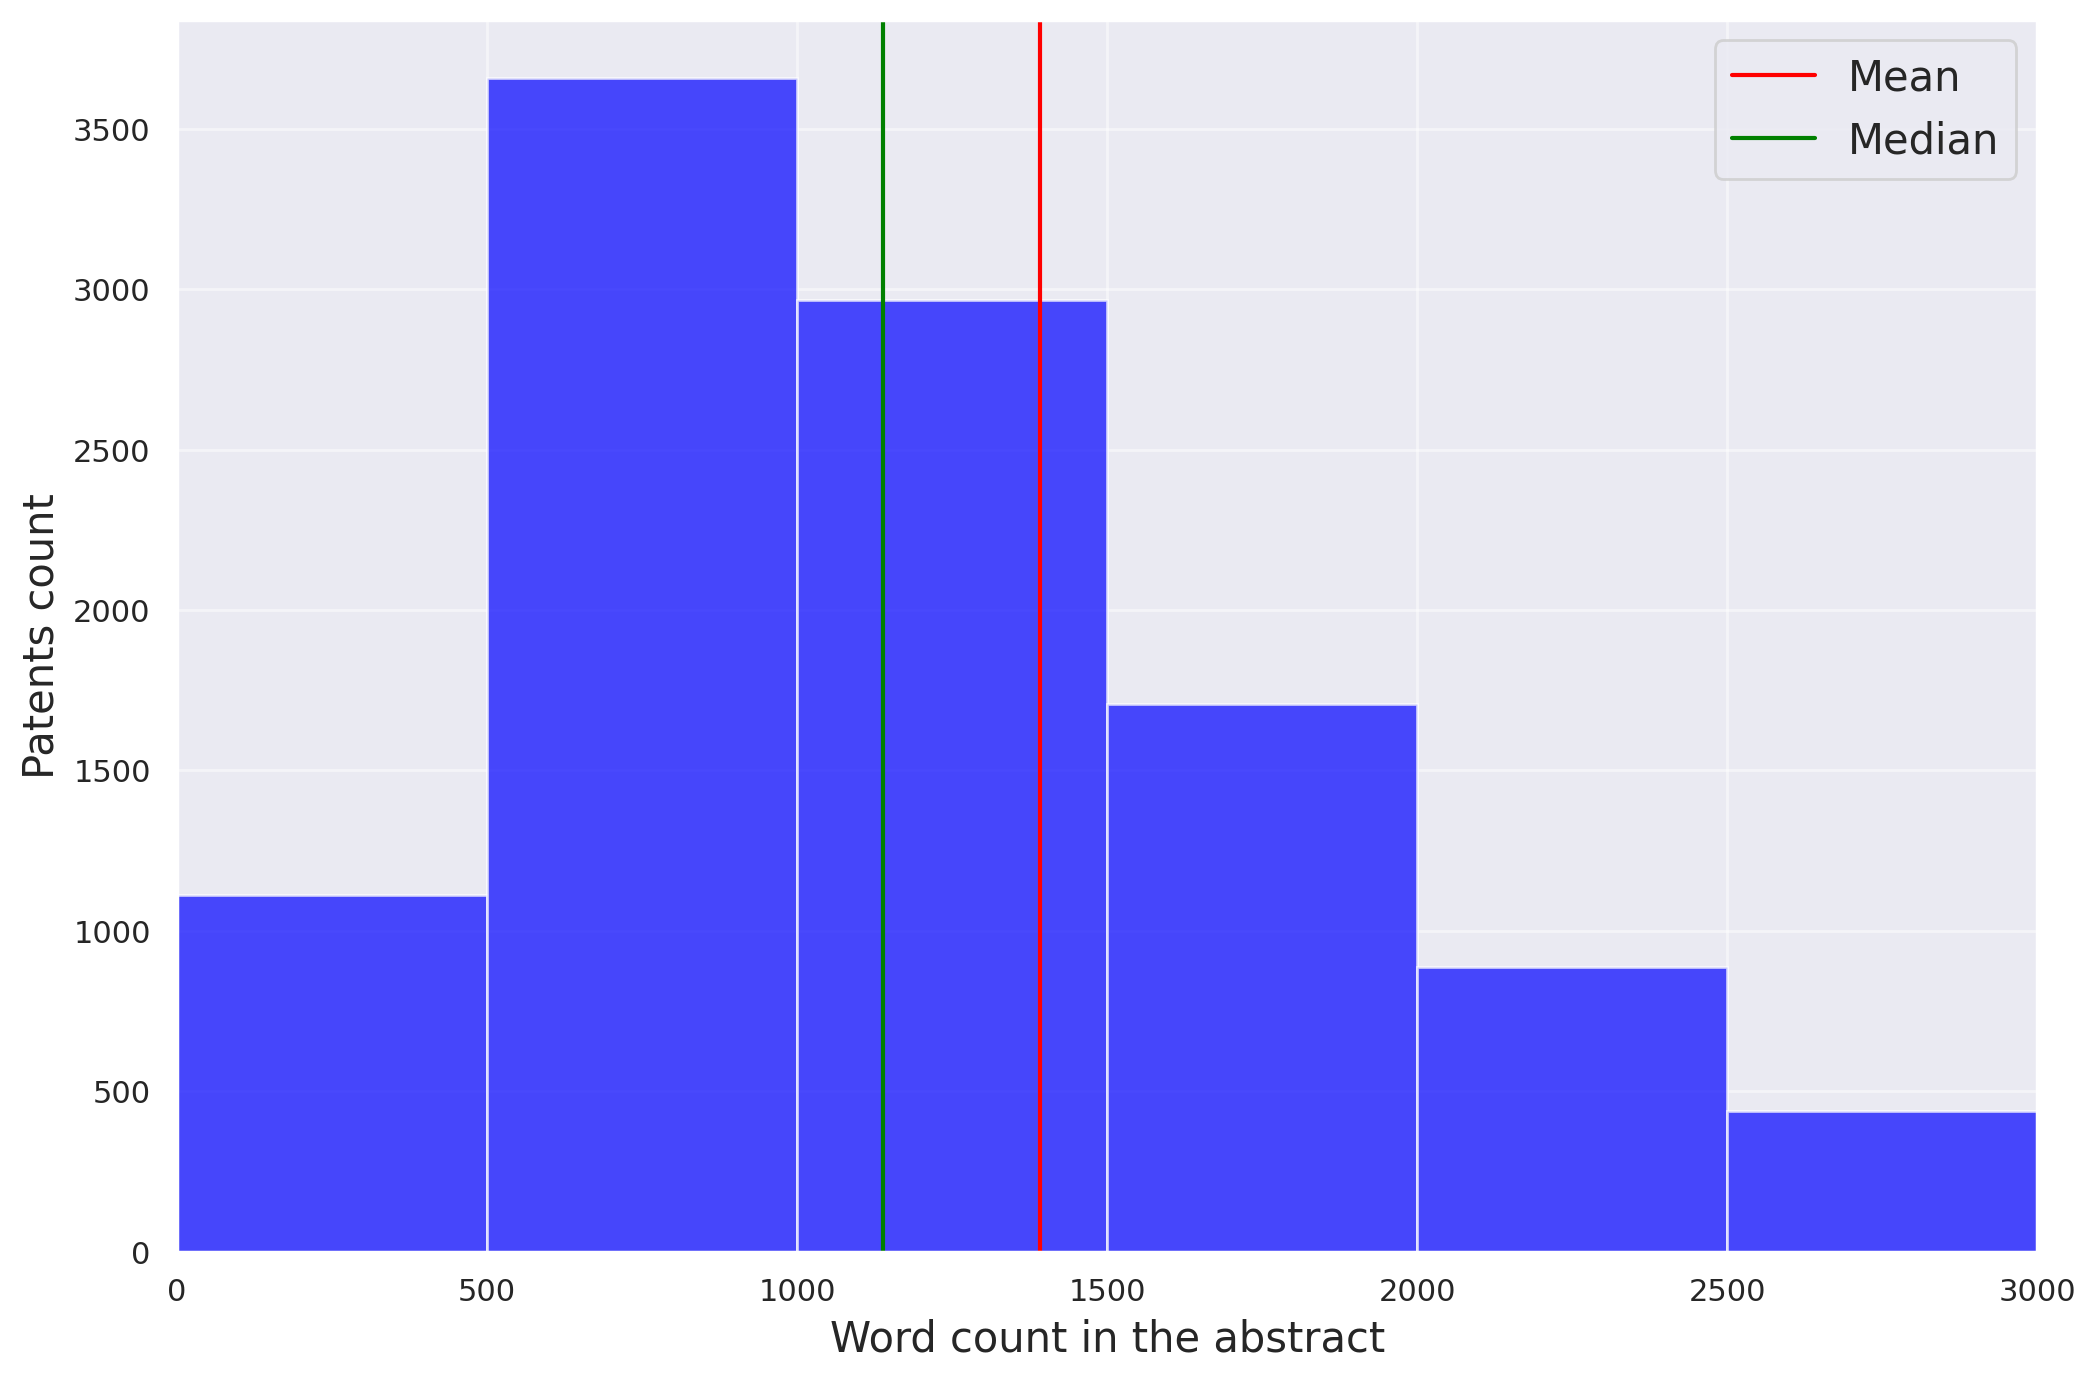

In [61]:
plt.figure(figsize = (12,8))
plt.hist(words_count_list, ls = '-', bins = [0, 500, 1000, 1500, 2000, 2500, 3000], color = 'blue', alpha = 0.7)
plt.xlabel("Word count in the abstract", fontsize=15)
plt.ylabel("Patents count", fontsize=15)
plt.xlim(0, 3000)
plt.axvline(x = word_count_mean, c = 'red', label = "Mean")
plt.axvline(x = word_count_median, c = 'green', label = "Median")
plt.legend(fontsize = 15)
plt.grid(alpha = 0.5)
plt.show()

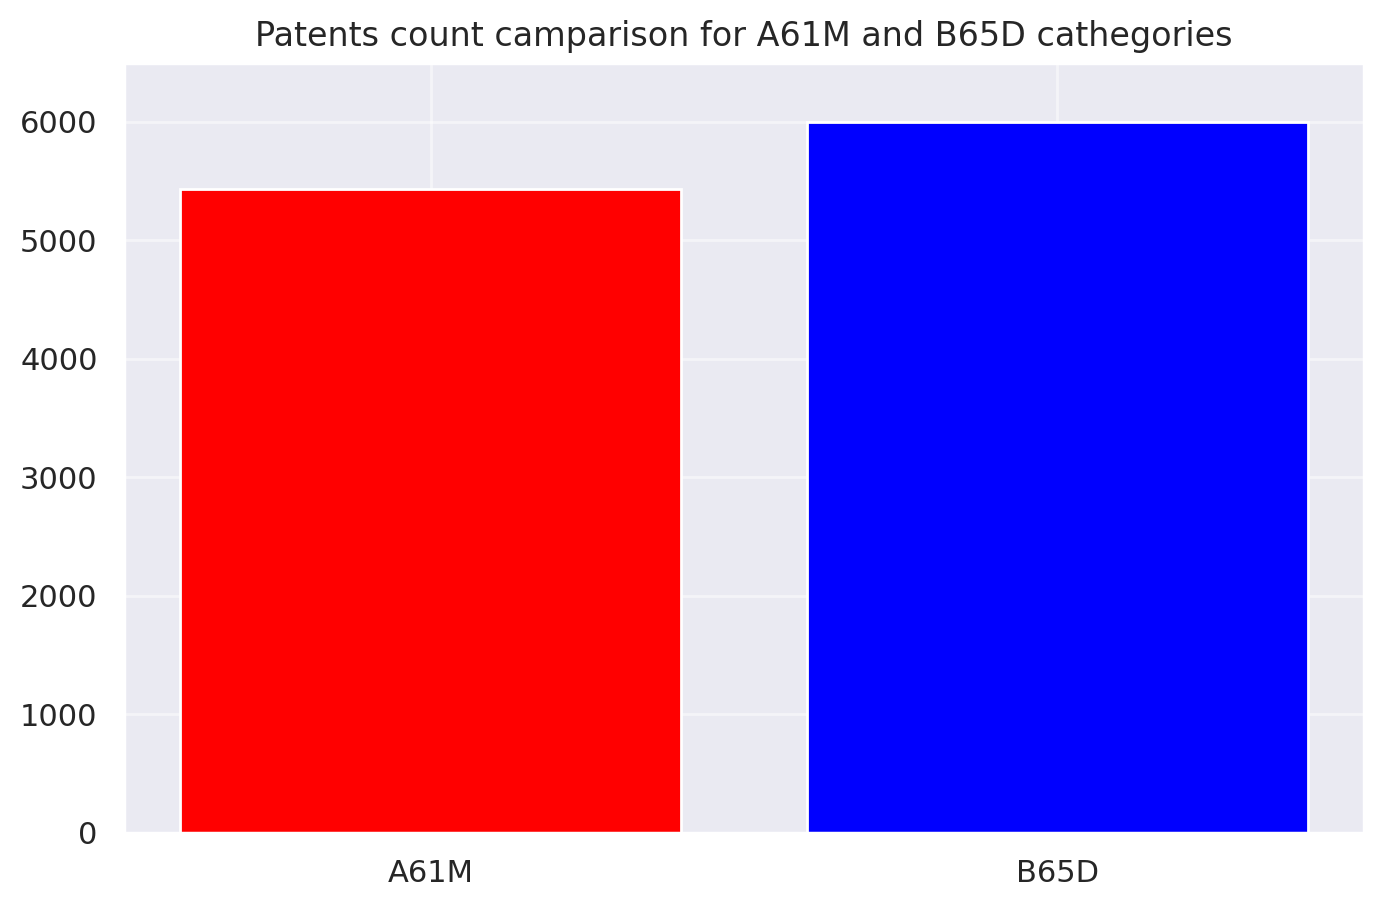

In [62]:
plt.figure(figsize=(8, 5))
plt.ylim((0, 6500))
plt.grid(alpha = 0.5)
plt.bar(("A61M", "B65D"), (5434, 5999), color=('red', 'blue'))
plt.title("Patents count camparison for A61M and B65D cathegories")
plt.show()

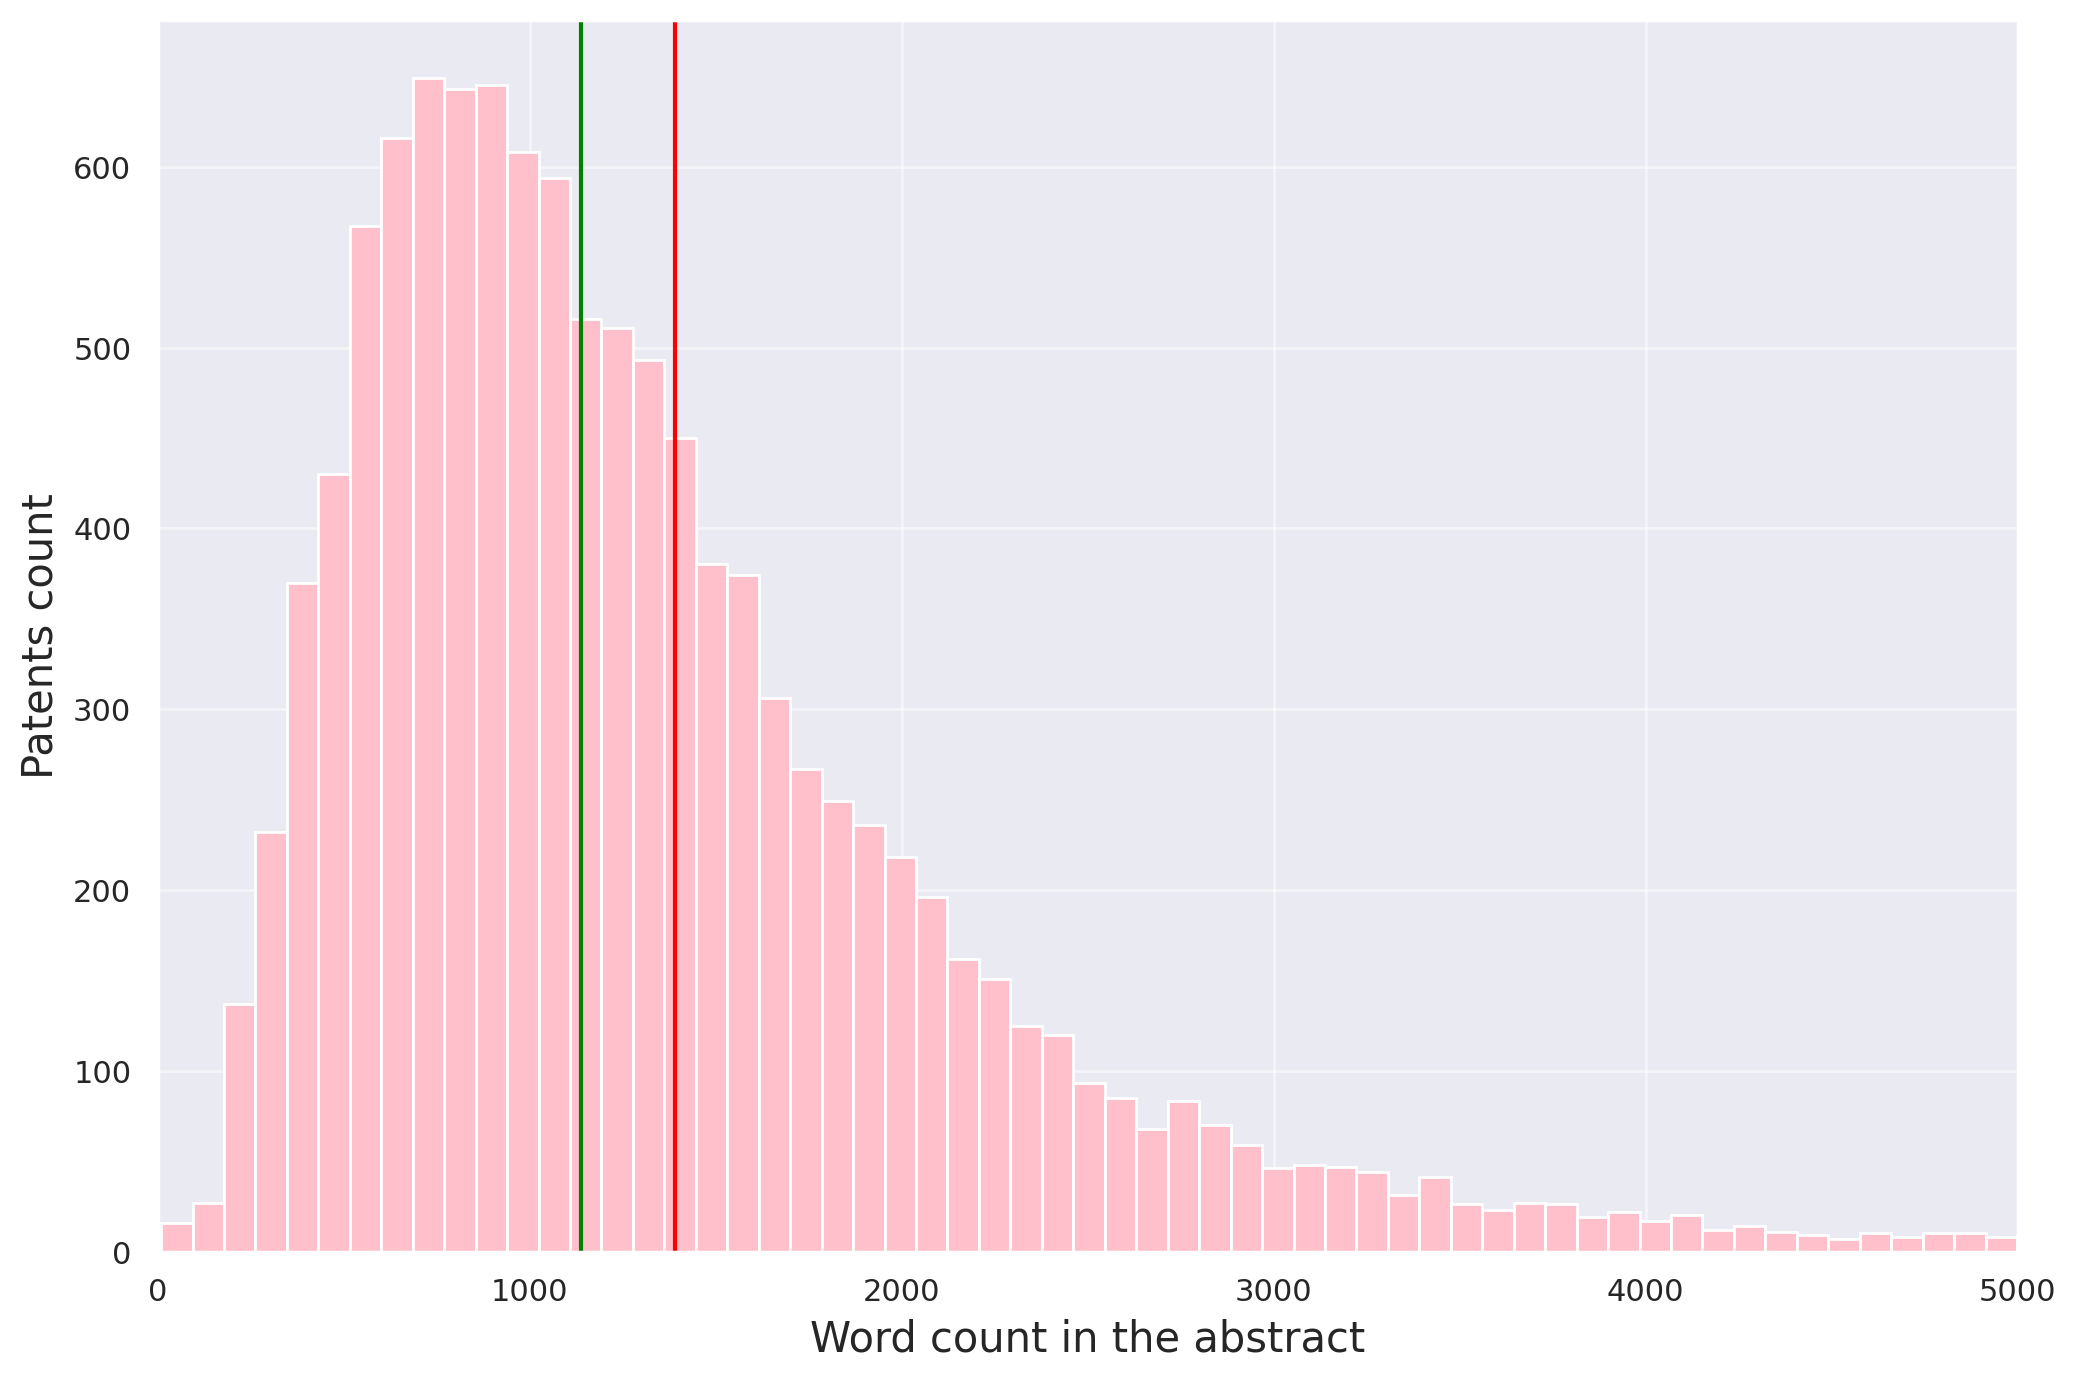

In [133]:
plt.figure(figsize = (12, 8))
plt.hist(words_count_list, ls = '-', color = 'pink', alpha = 1, bins = 'auto')
plt.xlabel("Word count in the abstract", fontsize = 15)
plt.ylabel("Patents count", fontsize = 15)
plt.xlim(0, 5000)
plt.axvline(x = word_count_mean, c = 'red')
plt.axvline(x = word_count_median, c = 'green')
plt.grid(alpha = 0.5)

plt.show()

In [64]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
import os

In [65]:
patents[1]['classification']['main']

'B65D 6302'

In [66]:
labels = []
for patent in patents:
    patent_cathegory = patent['classification']['main'][0:4]
    if patent_cathegory.startswith('A61M'):
      labels.append([1,0])
    else:
      labels.append([0,1])

In [67]:
abstracts = [patent[abstract_key] for patent in patents]

In [68]:
tokenizer  = Tokenizer()
tokenizer.fit_on_texts(abstracts) #Words to vectors library.

In [69]:
sequences = tokenizer.texts_to_sequences(abstracts)

In [70]:
word_index = tokenizer.word_index

In [71]:
data_sequences = pad_sequences(sequences, maxlen = 100)

In [72]:
def split_data(data_sequences, labels, split):
    indices = np.arange(data_sequences.shape[0])
    np.random.shuffle(indices)
    data_sequences = data_sequences[indices]
    labels = labels[indices]
    nb_validation_samples = int(split * data_sequences.shape[0])

    x_train = data_sequences[:-nb_validation_samples].astype(np.float32)
    y_train = labels[:-nb_validation_samples].astype(np.float32)
    x_val = data_sequences[-nb_validation_samples:].astype(np.float32)
    y_val = labels[-nb_validation_samples:].astype(np.float32)
    return x_train, y_train, x_val, y_val

In [73]:
def train_test_data(split):
    return split_data(data_sequences, np.array(labels), split), word_index

In [74]:
(x_train, y_train, x_val, y_val), word_index = train_test_data(0.5)

print('Shape of data tensor:', x_train.shape, x_val.shape)
print('Shape of label tensor:', y_train.shape, y_val.shape)

Shape of data tensor: (5717, 100) (5716, 100)
Shape of label tensor: (5717, 2) (5716, 2)


In [75]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPool1D, LSTM
from keras.metrics import categorical_accuracy

In [76]:
from pathlib import Path

def embedding_matrix(word_index):
    dim = 300
    print("Loading GloVe word vectors...")
    embeddings_index = {}
    with open("/content/drive/My Drive/Colab Notebooks/glove.42B.300d.txt") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [77]:
EMBEDDING_DIM = 300
emb_matrix = embedding_matrix(word_index)

Loading GloVe word vectors...
Found 1917494 word vectors.


In [78]:
from keras.layers import Embedding

def embedding_layer(x_train, word_index):
    return Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[emb_matrix],
                     input_length=x_train.shape[1],
                     trainable=False)

In [79]:
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPool1D, LSTM
from keras.metrics import categorical_accuracy

In [80]:
def model3(embedding, n_cats):
    model = Sequential()
    model.add(embedding)
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_cats, activation='sigmoid'))

    model.compile(loss = "binary_crossentropy",
                  optimizer = 'adam',
                  metrics = [categorical_accuracy])

    print(model.summary())
    return model

In [81]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience=3)

In [82]:
model = model3(embedding_layer(x_train, word_index), y_train.shape[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          22353300  
                                                                 
 dropout_1 (Dropout)         (None, 100, 300)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 128)           115328    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                      

In [83]:
x_train[0,0].dtype, y_train[0,0].dtype, x_val[0,0].dtype, y_val[0,0].dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [84]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
179/179 [==============================] - 14s 75ms/step - loss: 0.3197 - categorical_accuracy: 0.8672 - val_loss: 0.1809 - val_categorical_accuracy: 0.9300
Epoch 2/10
179/179 [==============================] - 13s 74ms/step - loss: 0.1816 - categorical_accuracy: 0.9300 - val_loss: 0.1661 - val_categorical_accuracy: 0.9368
Epoch 3/10
179/179 [==============================] - 13s 74ms/step - loss: 0.1384 - categorical_accuracy: 0.9468 - val_loss: 0.1554 - val_categorical_accuracy: 0.9384
Epoch 4/10
179/179 [==============================] - 13s 75ms/step - loss: 0.0994 - categorical_accuracy: 0.9627 - val_loss: 0.1654 - val_categorical_accuracy: 0.9375
Epoch 5/10
179/179 [==============================] - 13s 75ms/step - loss: 0.0601 - categorical_accuracy: 0.9797 - val_loss: 0.1918 - val_categorical_accuracy: 0.9358
Epoch 6/10
179/179 [==============================] - 12s 66ms/step - loss: 0.0416 - categorical_accuracy: 0.9867 - val_loss: 0.1907 - val_categorical_accuracy:

# Validation

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import pandas as pd
import numpy as np
import os

sns.set(color_codes=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [100]:
pred_val = model.predict(x_val).argmax(axis=1)

179/179 [==============================] - 3s 17ms/step


In [103]:
y_final = y_val.argmax(axis=1)

In [104]:
precision_score(y_final, pred_val)

0.9450808625336927

In [110]:
print(f"Model results:\n Precision: {precision_score(y_final, pred_val)},\n Recall:{recall_score(y_final, pred_val)},\n Accuracy: {accuracy_score(y_final, pred_val)},\n F1 score: {f1_score(y_final, pred_val)}.")

Model results:
 Precision: 0.9450808625336927,
 Recall:0.9340659340659341,
 Accuracy: 0.9368439468159552,
 F1 score: 0.9395411153910569.
